## Google Trends - Ethipia Economic Monitor

The Google trends analysis presetnted here is to support analytical activities to monitor impacts of economic reforms rolled out in 2024. 

The cornerstone of these economic reforms was the introduction of FX market liberalization at the end of July 2024 which led to a <u> substantial devaluation of the Ethiopian Birr</u>. While these measures are expected to boost productive capacity of households in the medium to long term, prices, employment, and incomes may be hit in the short-term transition period.

To better understand the impact on population, we've gathered data from Google's searches to see how the interest in particular search terms have been changing over time. 

<b> Google Trends </b> provides access to a largely unfiltered sample of actual search requests made to Google. It’s anonymized (no one is personally identified), categorized (determining the topic for a search query) and aggregated (grouped together). This allows us to display interest in a particular topic from around the globe or down to city-level geography.

In [27]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime as dt

from googleapiclient.discovery import build

from credentials import get_key

import warnings
warnings.filterwarnings("ignore")

from matplotlib import font_manager as fm
fm.fontManager.addfont("../../data/google_trends/Noto_Serif_Ethiopic/NotoSerifEthiopic-VariableFont_wdth,wght.ttf")
plt.rcParams['font.family'] = ['Noto Serif Ethiopic']

%matplotlib inline

In [2]:
class Google():
    """
    Wrapper class for handling authentication and requests (GET) to Google API
    
    Parameters
    ----------
    token : str
        Google API token
        
    Notes
    -----
    For more information, please see https://developers.google.com/apis-explorer
    """
    
    def __init__(self, token=None):
        self.TOKEN = token if token else os.getenv("GOOGLE_TOKEN")
        
    @property
    def service(self):
        """Authenticate and instantiate Google API service"""
        return build('trends', 'v1beta', static_discovery=False, developerKey=self.TOKEN)

    def get(self, method, params):
        """Get result from Google API method"""
        return getattr(self.service, method)(**params).execute()
    
    
    def download(self, method, params):
        """Download result from Google API method"""
        
        if not method in ["getGraph", "getTimelinesForHealth"]:
            raise NotImplementedError("Method not supported.")
        
        result = self.get(method, params)
        
        df = pd.json_normalize(result["lines"], meta=["term"], record_path=["points"]) 
        
        params = "+".join([f"{k}={v}" for k, v in params.items()])
        name = f"{method}+{params}.csv"

        df.to_csv(name, index=False)

In [3]:
google = Google(get_key())

For the purpose of this analysis, we've broken down search terms into six major categories. These categories broadly caputre people's interest over time and provides high level insights into their behavior. These categories include:
- Exchange Rate
- Devaluation
- Prices
- Natural Disasters
- Conflicts
- Other relevant terms

These terms have been collected from Google's related terms and topics search, as well as brainstorming with the team. 

#### Topic based search

In [4]:
forex_terms = {"Exchange Rate": ["ethiopian immigration", 'ethiopian birr', "ethiopia black market", "National Bank of Ethiopia", 
               "Central Bank of Ethiopia", "Awash Bank exchange rate", 
            "Dashen Bank exchange rate", "national bank of ethiopia exchange rate", "gold price in ethiopia",
            "የአሜሪካ ዶላር", "ኢትዮጵያ ንግድ ባንክ የዶላር ዋጋ", "የምንዛሪ ተመን"]}

deval_terms = {"Devaluation" : ["devaluation", "birr devaluation", "የብር ውድቀት", "የዋጋ ግሽበት", "የኢትዮጵያን የዋጋ ንረት", 
                                "Currency depreciation",
               "ethiopian birr devaluation", "devaluation of ethiopian birr", "money devaluation"]}

price_terms = {"Prices" : ["fuel price in ethiopia", "fuel price", "gasoline price", "gold price", "gold price in ethiopia",
               "silver price in ethiopia"]}

disaster_terms = {"Natural Disasters" : ["earthquake", "landslides", "floods"]}

conflict_terms = {"Conflict" : ["somaliland", "tigray conflict", "civil war", "tigray war", "tplf"]}

other_terms = {"Corrdior Development Project" : ["piassa"]}

In [6]:
df = pd.DataFrame()

for dicts in [forex_terms, deval_terms, price_terms, disaster_terms, conflict_terms, other_terms]:
    
    for topic, lis in dicts.items(): 
        for term in lis:
            filters = {
                        'terms': term,
                        'restrictions_geo': "ET", ## contrained to Ethiopia
                        'restrictions_startDate': "2024-01", ## start date for the data
                        'restrictions_endDate' : "2024-10" ## end date for the data (optional)
                    }
            
            r = google.get('getGraph', filters)

            df_ = pd.DataFrame(r['lines'][0]['points'])
            df_['term'] = term
            df_['topic'] = topic

            df = pd.concat([df, df_])

In [7]:
#df.to_csv("../../data/google_trends/topic_searchterms.csv", index = False)

In [49]:
#df.groupby(['topic', 'date'])['value'].mean().reset_index().pivot(index = 'date', columns = 'topic', values = 'value').plot(figsize = [20, 8])

In [50]:
def get_topic_charts(df, topic):
    """"
    Function to create plots for a selected topic

    Inputs:
    df : pandas dataframe with Google's data from API
    tpoic : topic to plot data for

    Returns
    None
    """

    dftemp = df.query(f"topic == '{topic}'")
    dftemp.date = dftemp.date.apply(pd.to_datetime)
    dftemp = dftemp.pivot(index = 'date', columns = 'term', values = 'value')

    for cols in dftemp.columns:
        if len(dftemp[cols].unique()) == 1:
            del dftemp[cols]


    fig, ax = plt.subplots(1, 1)
    dftemp.plot(ax = ax, figsize = (15, 8))
    if topic == "Conflict":
        ax.axvline(pd.Timestamp('2024-01-01'),color='r', ls = '-.', lw = 2, label = "Somaliland news")
    elif topic == "Natural Disasters":
        pass
    else:
        ax.axvline(pd.Timestamp('2024-07-28'),color='r', ls = '-.', lw = 2, label = "Devaluation date")
    plt.legend()
    plt.ylabel("Normalized search score", fontsize = 10);
    plt.xlabel('')
    ax.set_title(f"Relative Google Search Trends for {topic} related terms", fontsize = 12);

This section uses the data gatehred from Google's API and creates charts to see the trends for each of the search terms. In cases where its relevant, the benchmarking lines are shown for when FX market liberalization was annnounced and when [Somaliland agreed to lease land to Ethiopia to build a naval facility](https://www.crisisgroup.org/africa/horn-africa/ethiopia-somaliland/stakes-ethiopia-somaliland-deal). 

For the topics Exchange rate, Devaluation and Prices - we can see sharp increase in the search for July 28th 2024, which was the date when market liberalization news first came out. People were inersted in knowing the more about devaluation and what it meant for the ecnonomy. Search terms like `Ethiopian birr`, `Awash bank ecghange rate`, `National bank exchnage rate` all started trending. 

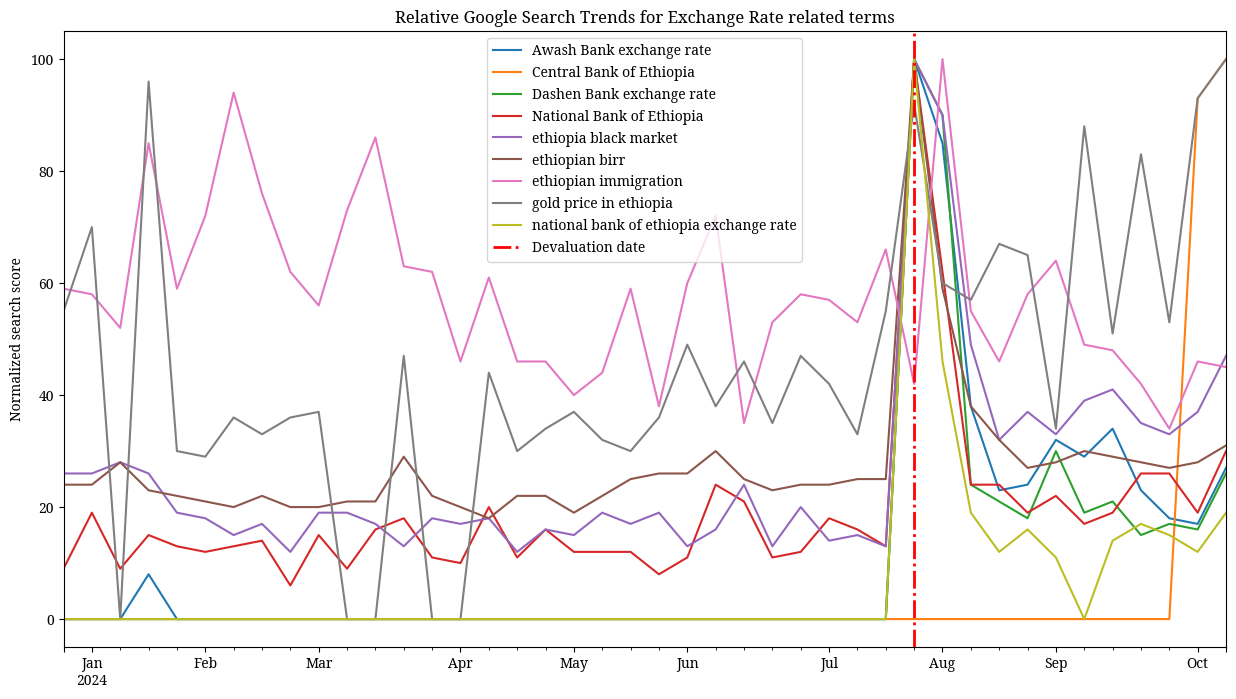

In [51]:
get_topic_charts(df, "Exchange Rate")

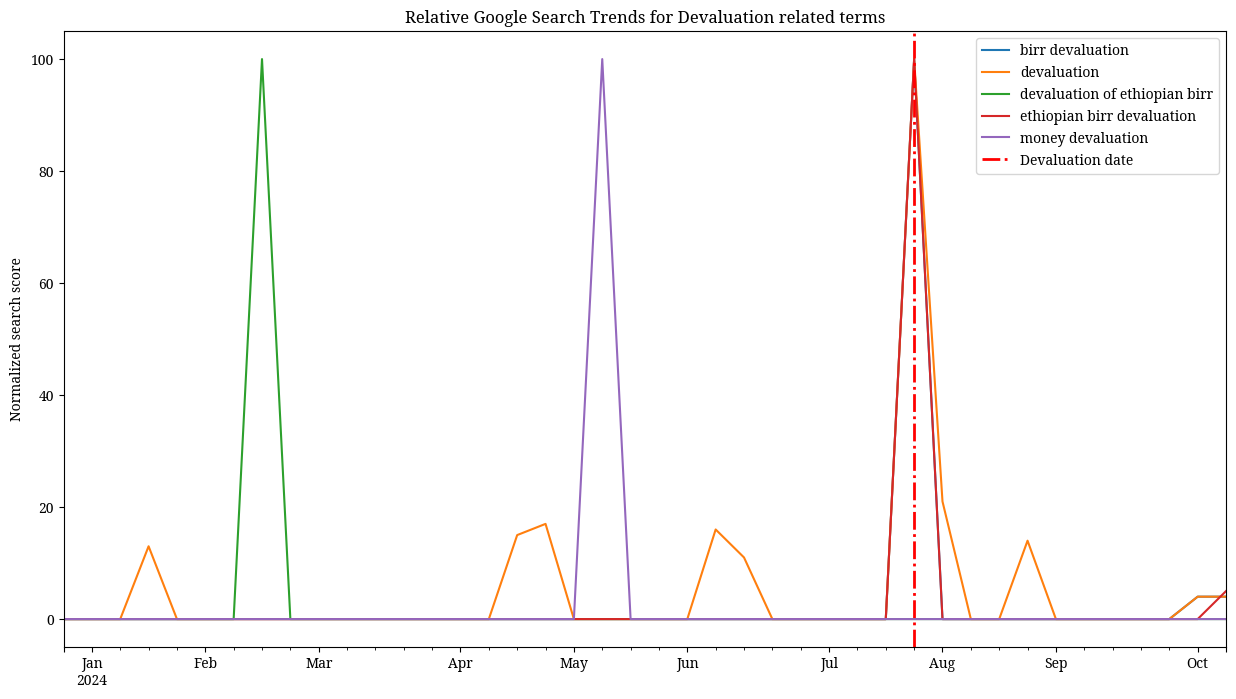

In [52]:
get_topic_charts(df, "Devaluation")

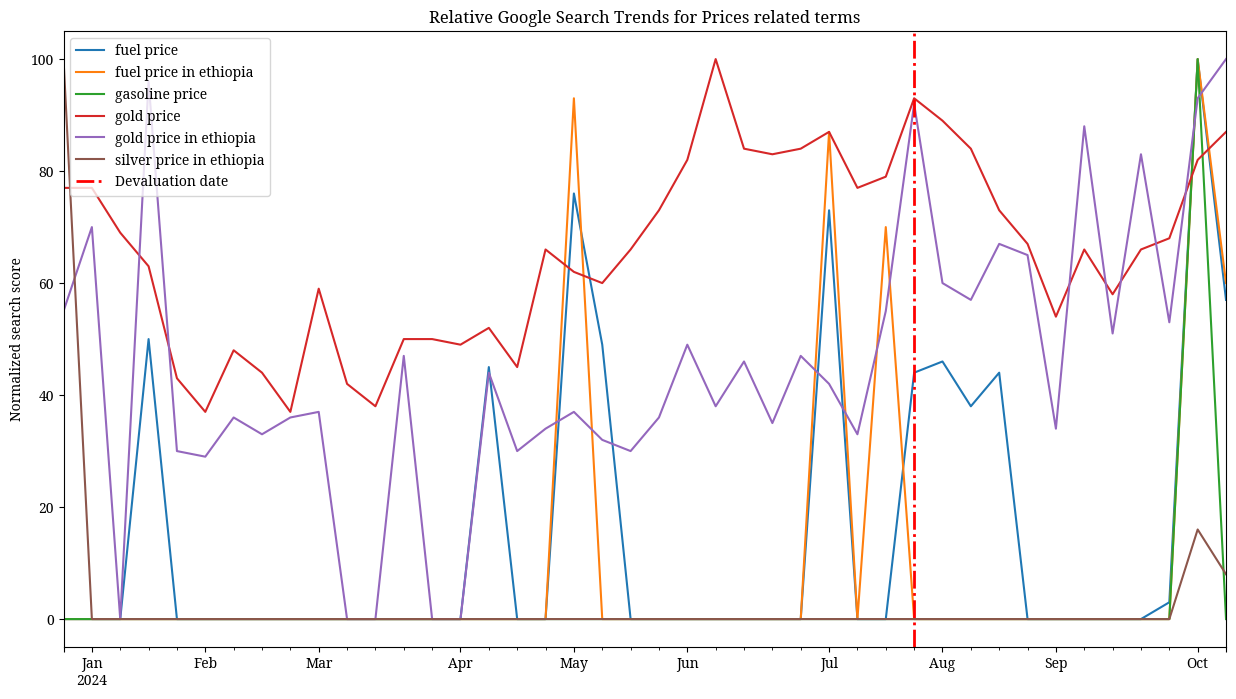

In [53]:
get_topic_charts(df, "Prices")

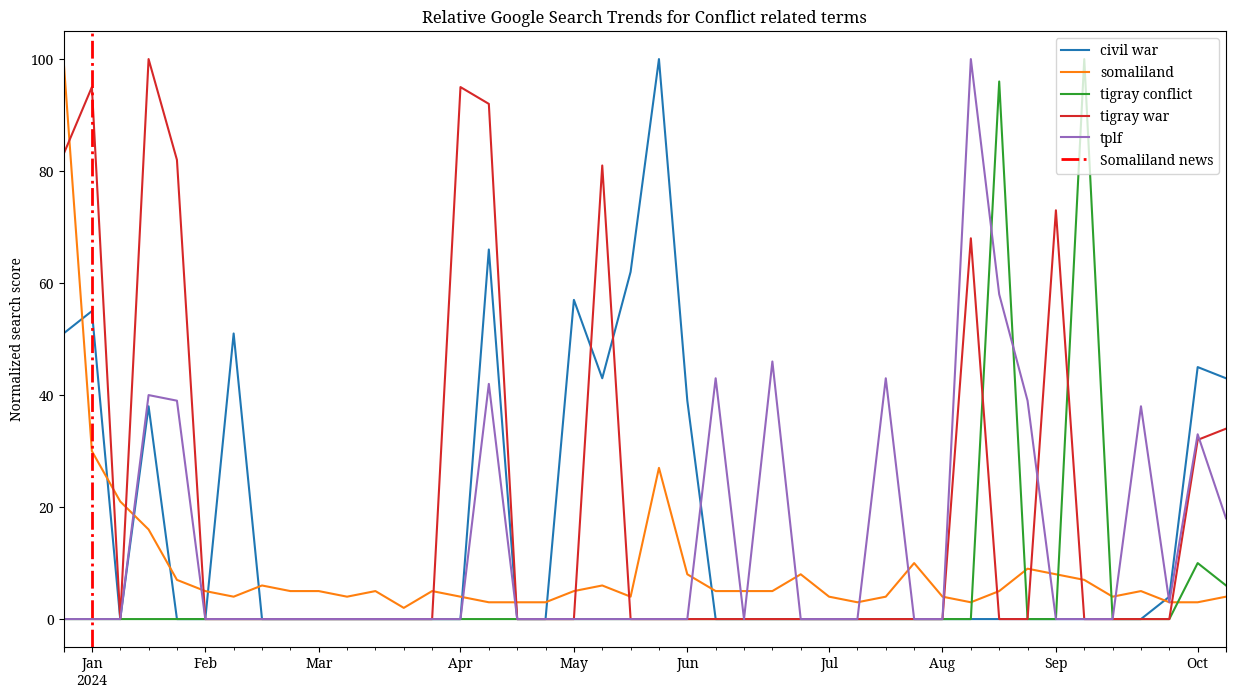

In [54]:
get_topic_charts(df, "Conflict")

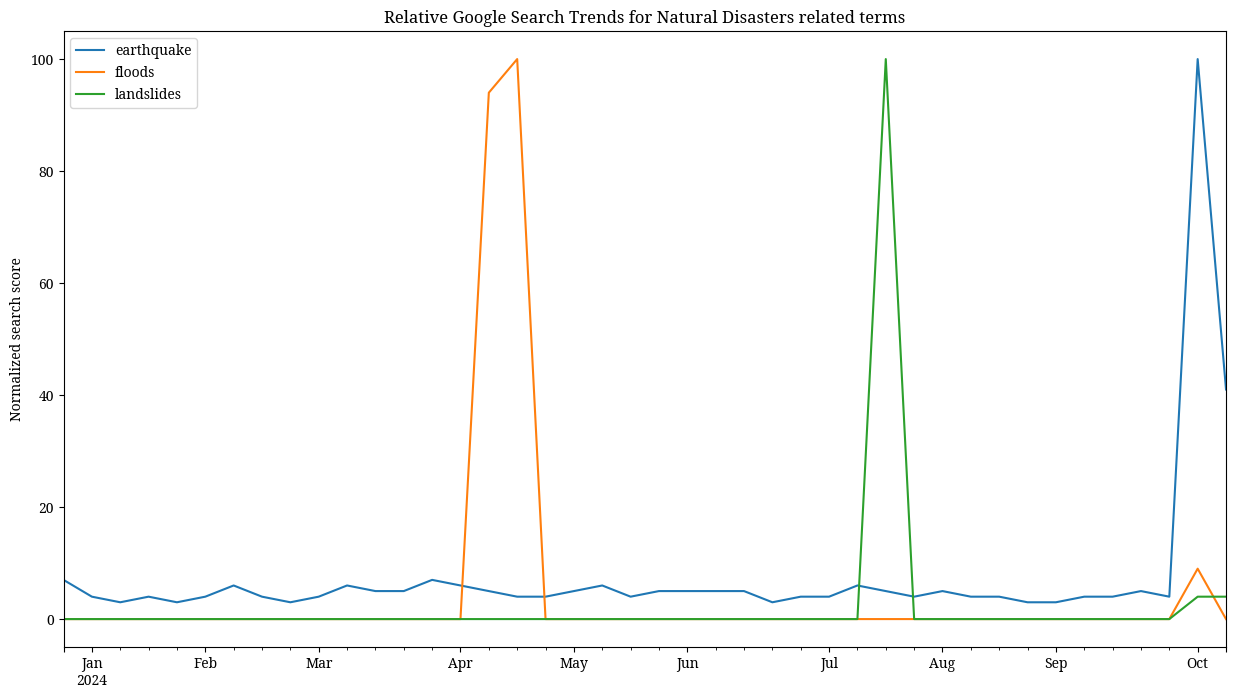

In [55]:
get_topic_charts(df, "Natural Disasters")

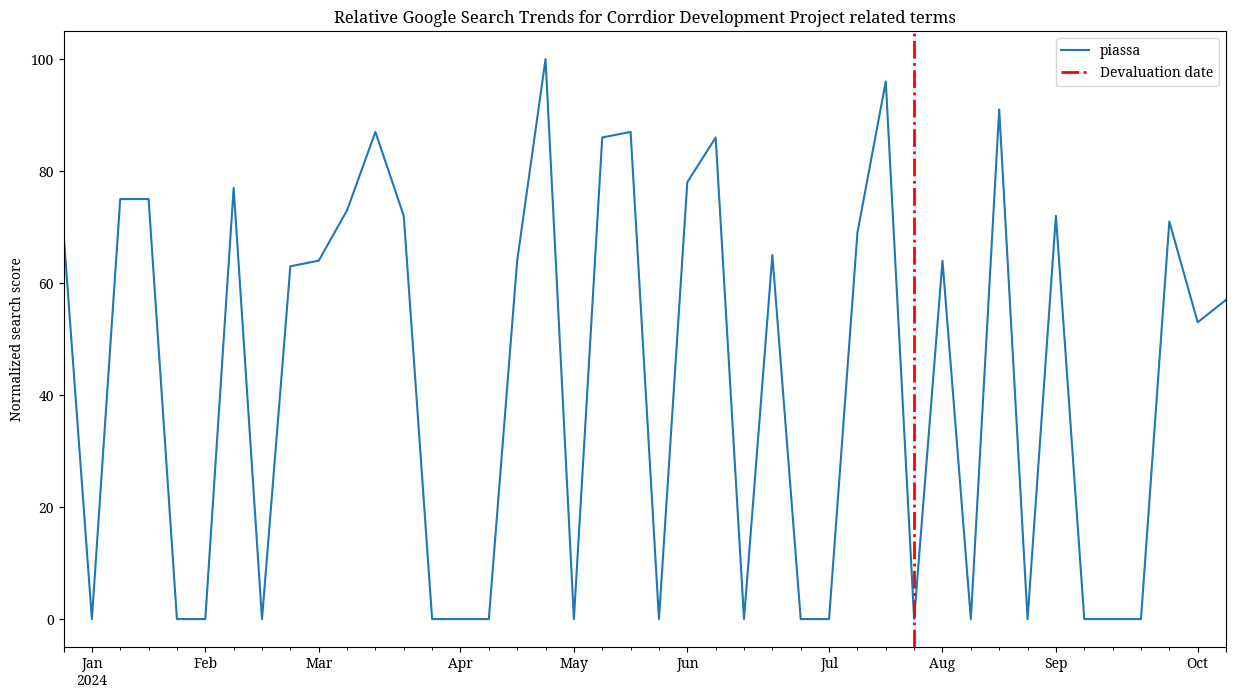

In [56]:
get_topic_charts(df, "Corrdior Development Project")

##### Word association

To show the search terms are linked to a Topic and to each other, we created a network chart to better understand the association between search terms and their topics. 

In [23]:
tdf = df.copy()

tdf['Type'] = "Undirected"
tdf['weight'] = 0.09

In [24]:
G = nx.from_pandas_edgelist(tdf, 
                            source='topic', 
                            target='term', 
                            edge_attr='weight')
print("No of unique characters:", len(G.nodes))
print("No of connections:", len(G.edges))

No of unique characters: 41
No of connections: 36


In [25]:
topics = list(tdf.topic.unique())
node_lis = list(G.nodes)

node_size = [1000 if i in topics else 200 for i in node_lis]
node_col = ['orange' if i in topics else 'grey' for i in node_lis]

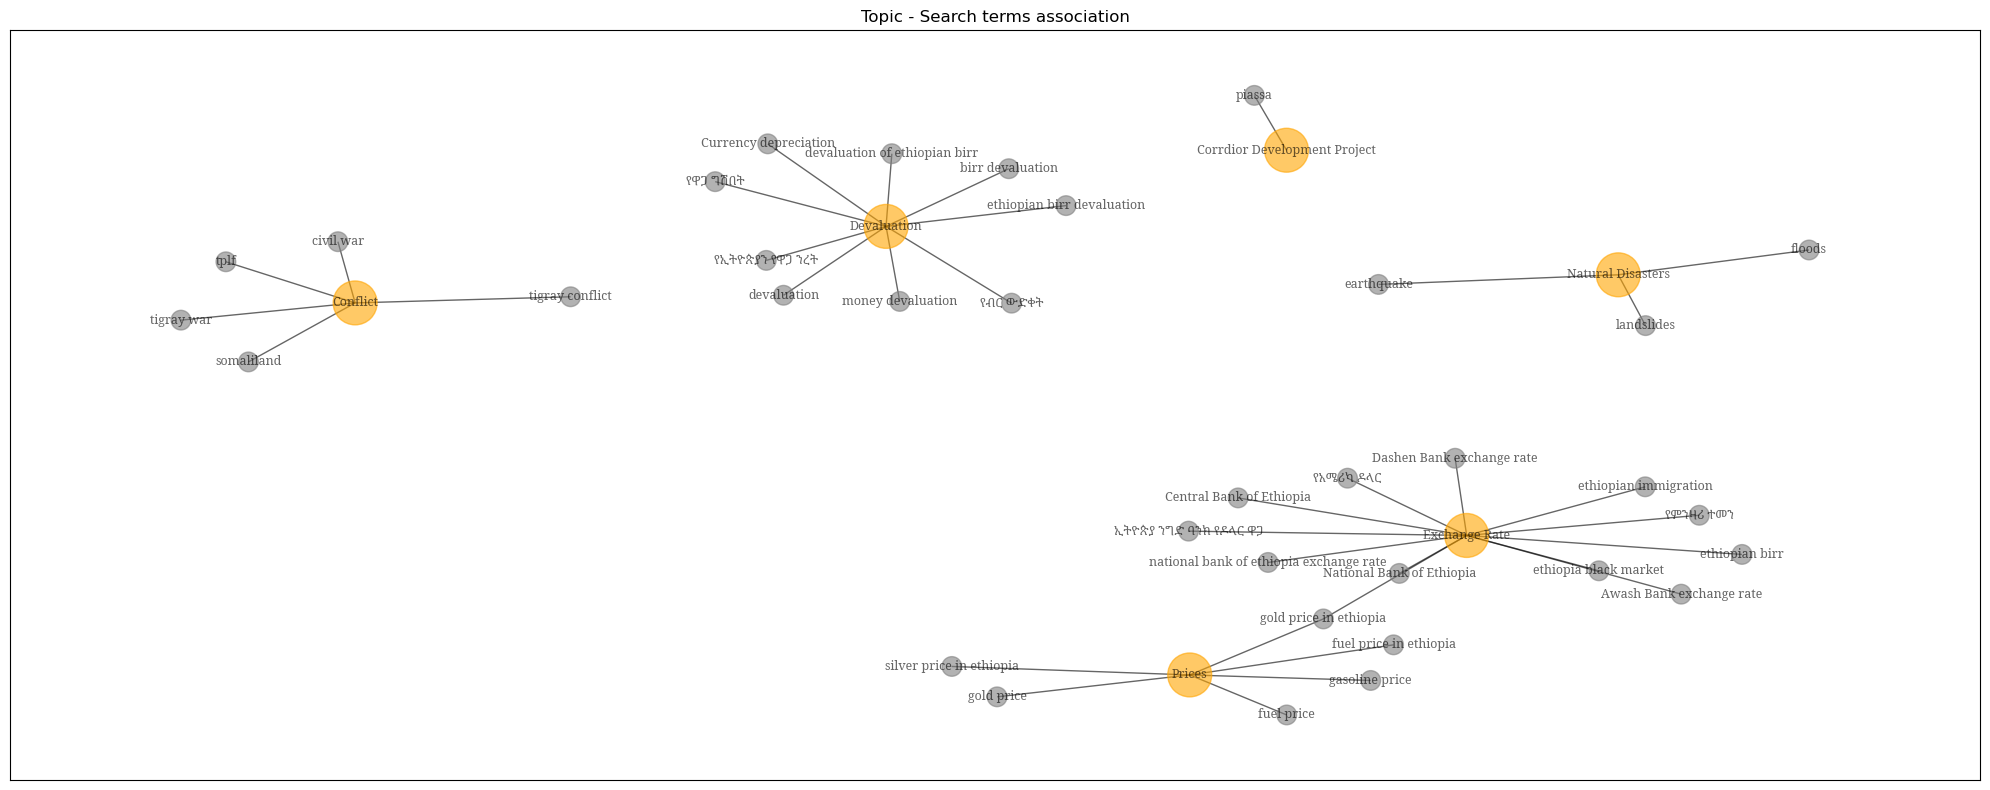

In [26]:
plt.figure(figsize=(20,8), dpi=100) 
nx.draw_networkx(G, node_size = node_size, node_color = node_col, alpha = 0.6,
                                          font_family = "Noto Serif Ethiopic", font_size = 9, with_labels = True,
                                          font_weight = 'bold')

plt.title("Topic - Search terms association from Google Trends data", fontsize = 12);

plt.tight_layout()

The team was also interested in knowing what was the global impact of Birr devaluation and the ongoing conflicts in the country. For this, we picked some search terms specific to Ethiopia and searched for them in other countries that have substantial Ethiopian presence i.e. United States, United Arab Emirates and South Africa. Unsurpisingly, there were sharp ticks in these search terms around the date of market liberalization announcement. 

#### Trends from other countries

In [19]:
us_terms = ['ethiopian birr', "ethiopia black market", '"usd to birr" + "birr to usd"', "National Bank of Ethiopia",
            "Central Bank of Ethiopia", "Awash Bank exchange rate", "ethiopia economic crisis",
            "Dashen Bank exchange rate", "national bank of ethiopia exchange rate", "gold price in ethiopia",
            "የአሜሪካ ዶላር", "ኢትዮጵያ ንግድ ባንክ የዶላር ዋጋ", "የምንዛሪ ተመን"]

uae_terms = ['ethiopian birr', "ethiopia black market", '"dirham to birr" + "birr to dirham"', "National Bank of Ethiopia",
             "Central Bank of Ethiopia", "Awash Bank exchange rate", 
            "Dashen Bank exchange rate", "national bank of ethiopia exchange rate", "gold price in ethiopia",
            "የአሜሪካ ዶላር", "ኢትዮጵያ ንግድ ባንክ የዶላር ዋጋ", "የምንዛሪ ተመን"]

sa_terms = ["ethiopian immigration", 'ethiopian birr', "ethiopia black market", '"rand to birr" + "birr to rand"', 
            "National Bank of Ethiopia", "Central Bank of Ethiopia", "Awash Bank exchange rate", 
            "Dashen Bank exchange rate", "national bank of ethiopia exchange rate", "gold price in ethiopia",
            "የአሜሪካ ዶላር", "ኢትዮጵያ ንግድ ባንክ የዶላር ዋጋ", "የምንዛሪ ተመን"]

#eth_terms = ["ethiopian immigration", "black market", "income tax rate", "ethiopia economic reform", 
#             "ethiopia exchange rate in ethiopia ", "commercial bank of ethiopia exchange rate",
#             "national bank of ethiopia", "gold price in ethiopia", ]

terms = {"US" : us_terms, "AE" : uae_terms, "ZA" : sa_terms}

In [16]:
con_df = pd.DataFrame()
for country, term_list in terms.items():
    
    for term in term_list:
        filters = {
                    'terms': term,
                    'restrictions_geo': country,
                    'restrictions_startDate': "2024-01",
                    'restrictions_endDate' : "2024-10"
                }
        
        r = google.get('getGraph', filters)

        df_ = pd.DataFrame(r['lines'][0]['points'])
        df_['term'] = term
        df_['country'] = country

        con_df = pd.concat([con_df, df_])

In [17]:
#con_df.to_csv("../../data/google_trends/country_searchterms.csv", index = False)

In [18]:
def get_country_charts(df, country):

    con_map = {"US" : "United States", "ZA" : "South Africa", "AE" : "UAE"}

    us_df = df.query(f"country == '{country}'")
    us_df.date = us_df.date.apply(pd.to_datetime)
    us_df = us_df.pivot(index = 'date', columns = 'term', values = 'value')

    for cols in us_df.columns:
        if len(us_df[cols].unique()) == 1:
            del us_df[cols]


    fig, ax = plt.subplots(1, 1)
    us_df.plot(ax = ax, figsize = (15, 8))
    ax.axvline(pd.Timestamp('2024-07-28'),color='r', ls = '-.', lw = 3, label = "Devaluation date")
    plt.legend()
    plt.ylabel("Normalized search score", fontsize = 10);
    plt.xlabel('')
    ax.set_title(f"Relative Google Search Trends for exchange rate related terms from {con_map[country]}", fontsize = 12);

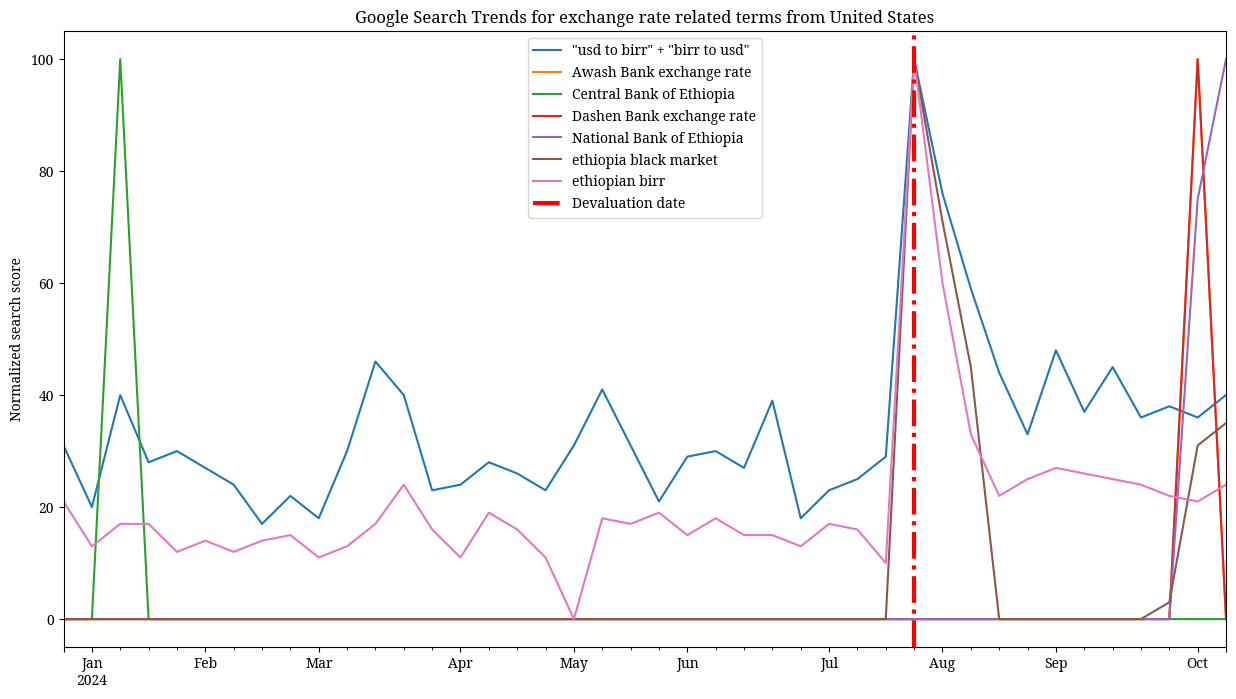

In [30]:
get_country_charts(con_df, 'US')

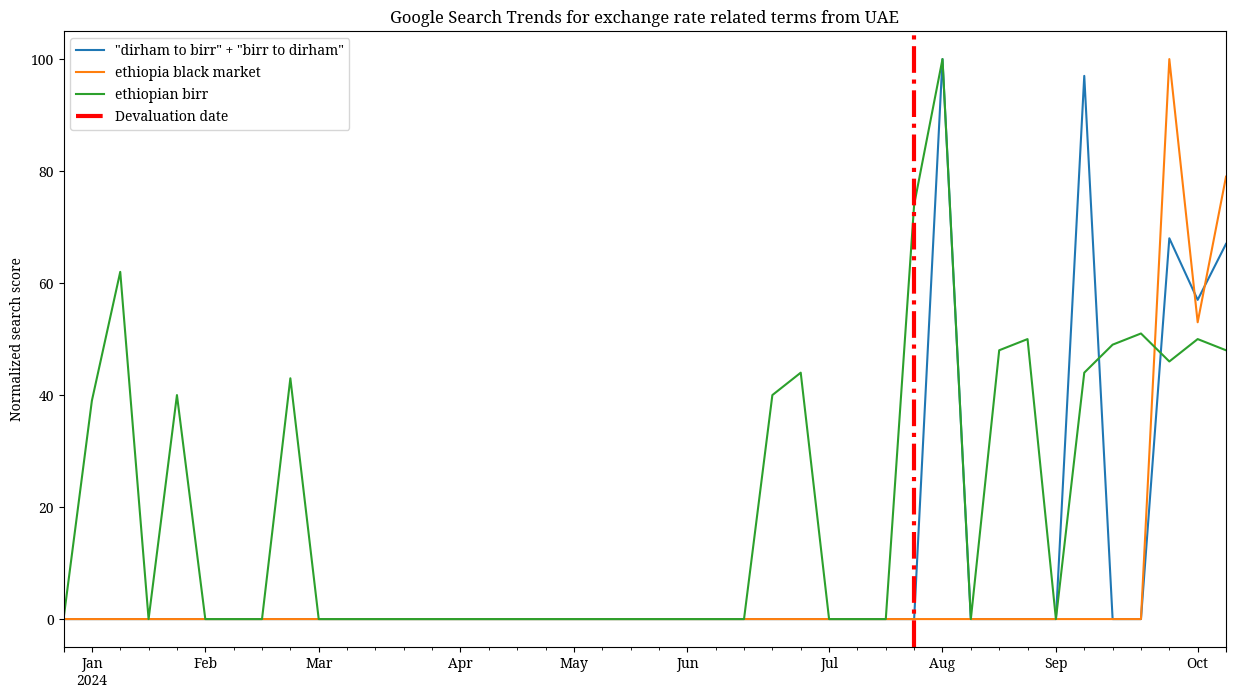

In [29]:
get_country_charts(con_df, 'AE')

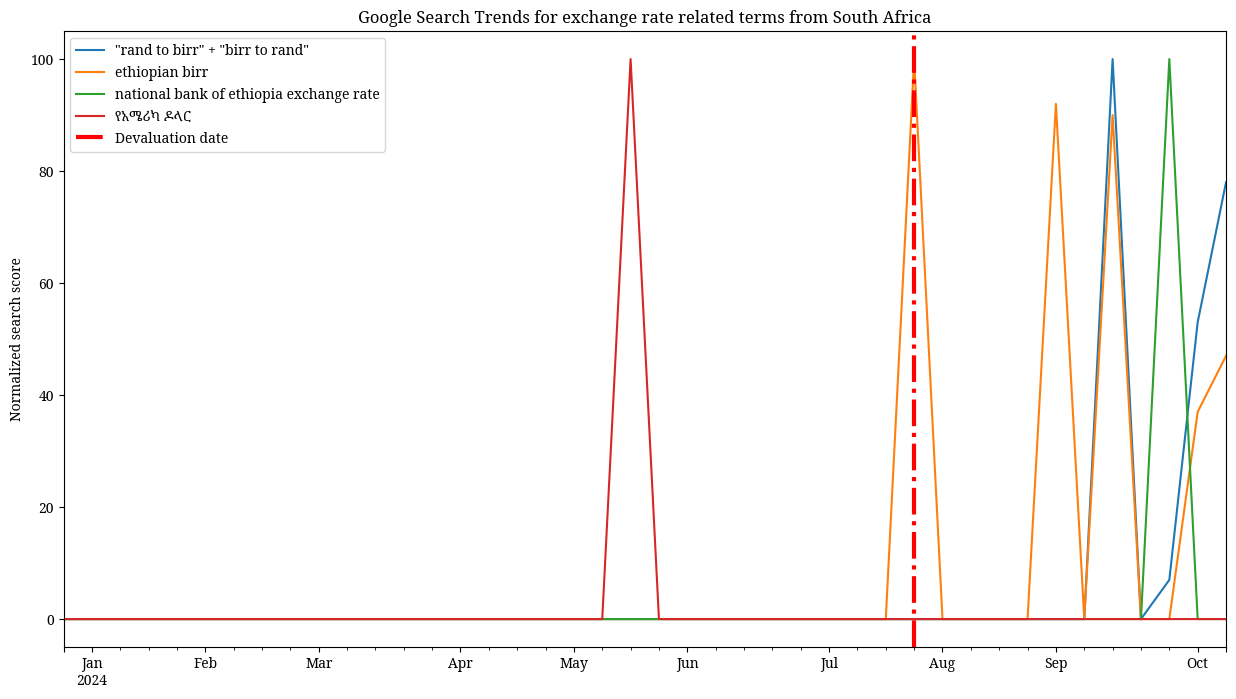

In [28]:
get_country_charts(con_df, 'ZA')

##### Word association for country data

In [31]:
cons = con_df.copy()

cons['Type'] = "Undirected"
cons['weight'] = 12

Gc = nx.from_pandas_edgelist(cons, 
                            source='country', 
                            target='term', 
                            edge_attr='weight')
print("No of unique characters:", len(Gc.nodes))
print("No of connections:", len(Gc.edges))

No of unique characters: 19
No of connections: 38


In [32]:
countries = list(cons.country.unique())
con_node_lis = list(Gc.nodes)

con_node_size = [1000 if i in countries else 200 for i in con_node_lis]
con_node_col = ['orange' if i in countries else 'grey' for i in con_node_lis]

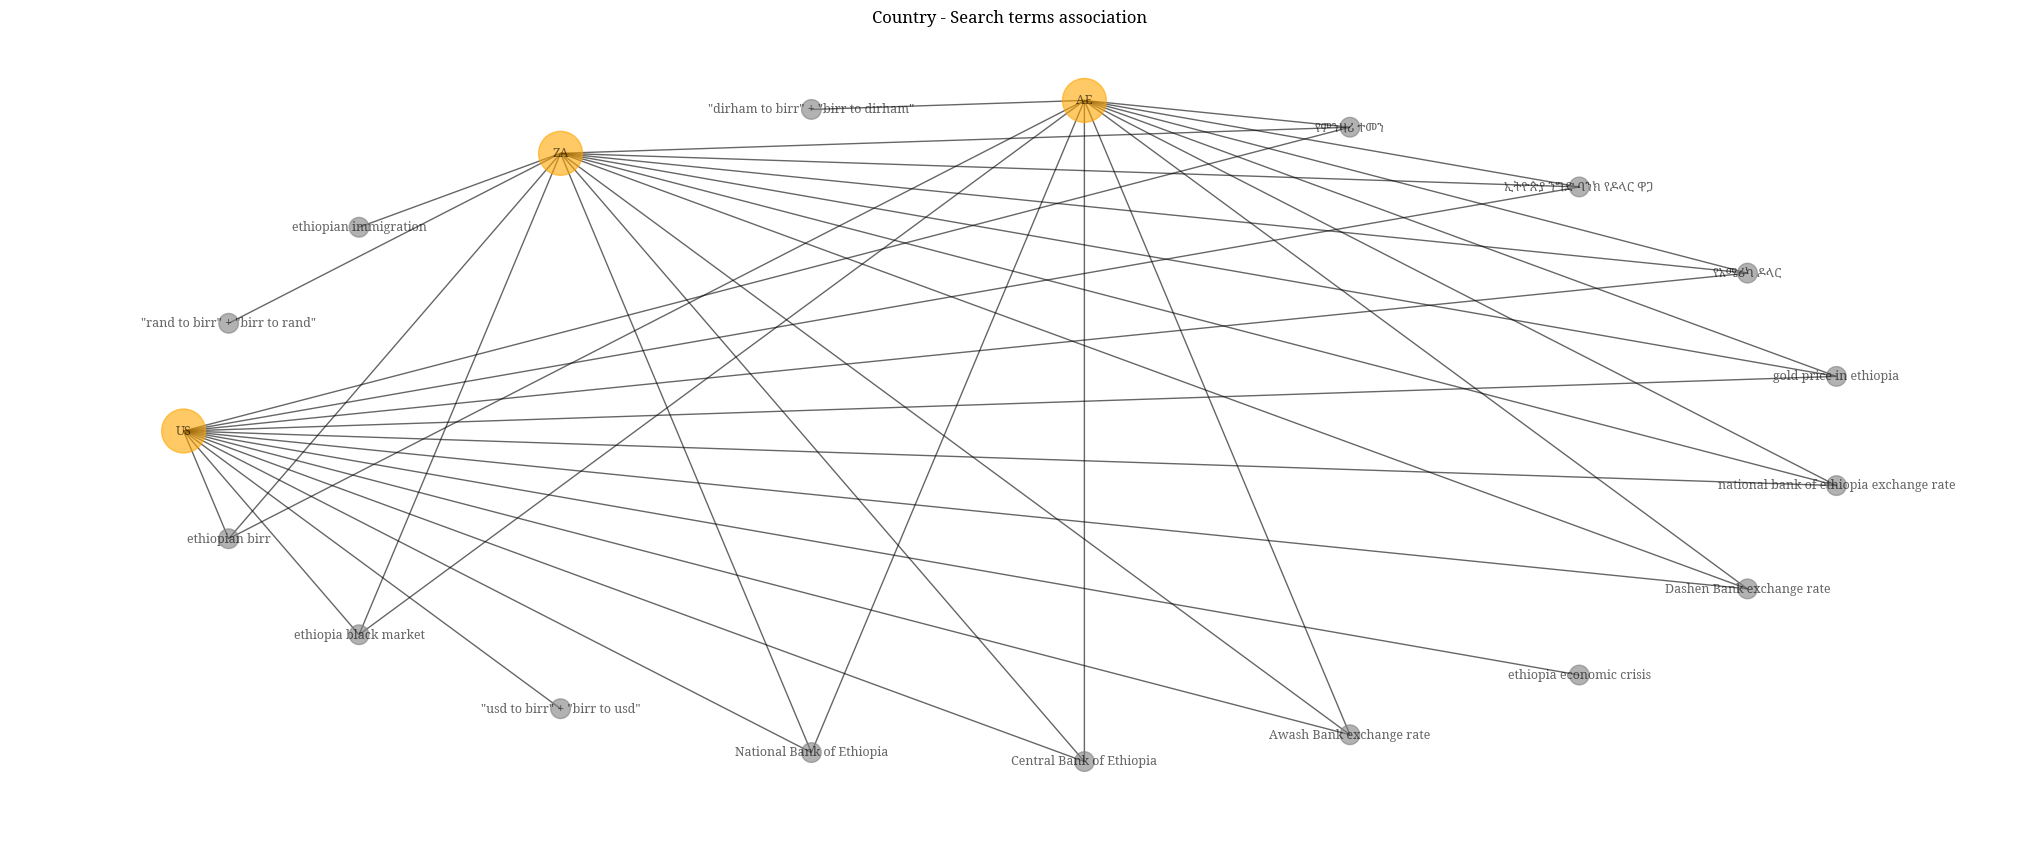

In [33]:
plt.figure(figsize=(20,8), dpi=100) 
nx.draw_shell(Gc, node_size = con_node_size, node_color = con_node_col, alpha = 0.6,
                                          font_family = "Noto Serif Ethiopic", font_size = 9, with_labels = True,
                                          font_weight = 'bold')

plt.title("Country - Search terms association from Google Trends data", fontsize = 12);

plt.tight_layout()